<a href="https://colab.research.google.com/github/tanoManzo/mimic_trajectories/blob/dev/MIMIC_TRAJECTORY_embeddings_02_collect_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Collection, Embeddings and Attitude

In [1]:
! pip install transformers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 35.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 42.6 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import torch 
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
from transformers import AutoModelForSequenceClassification
from sklearn.metrics.pairwise import cosine_similarity

load nursing notes subject-caregiver-chartdate

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
notes_path = "/content/drive/MyDrive/NIH/Data/"
notes_name = "NOTES_NURSING_TRAJECTORIES_01.csv"
df_notes = pd.read_csv(notes_path+notes_name)
df_notes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 531675 entries, 0 to 531674
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   ROW_ID      531675 non-null  int64 
 1   SUBJECT_ID  531675 non-null  int64 
 2   CGID        531675 non-null  int64 
 3   CHARTDATE   531675 non-null  object
 4   TEXT        531675 non-null  object
dtypes: int64(3), object(2)
memory usage: 20.3+ MB


## **Data Preprocessing**

extract nicu notes

In [5]:
def nicu_condition(x):
  words = ['nicu', 'neonatal']
  return any(word in x.lower() for word in words)

# get list of subject in nicu    
nicu_subject_ids = df_notes[df_notes['TEXT'].apply(lambda x: nicu_condition(x))]['SUBJECT_ID'].unique()

# get nicu notes
df_notes_nicu = df_notes[df_notes['SUBJECT_ID'].isin(nicu_subject_ids)]
df_notes_nicu

,ROW_ID,SUBJECT_ID,CGID,CHARTDATE,TEXT
0,2019399,25397,14720,2187-02-16,Social Work:\nHad provider meeting this aftern...
5,1792738,7984,14489,2153-08-30,NICU NURSING FAMILY MEETING AND PARENTING NOTE...
16,2019351,25397,14720,2187-02-08,Social Work:\n\n [**First Name8 (NamePattern2)...
46,2080962,32392,17603,2199-12-05,NPN DAYS\nRECEIVED [**Doctor Last Name **] AT ...
60,1740211,4578,14720,2152-08-09,"Social Work:\nFamily meeting held with mom, Dr..."
...,...,...,...,...,...
531667,1900603,15772,16864,2103-07-04,NPN 7a7p cont\nAgree with the above not writte...
531668,2034585,26106,19530,2191-05-13,Social Work:\nPlease refer to note in baby a's...
531670,1974281,21464,20104,2189-03-18,Procedure Note: UAC removal.\n\nUAC removed in...
531672,1735597,4205,16022,2163-06-11,Addendum\nAgree with above note and assessment...


## Data exploration 

check number of notes per patient/subject

number of notes: min=1, max=67, mean=2.425686113904758,  median=1.0


<Axes: xlabel='TEXT'>

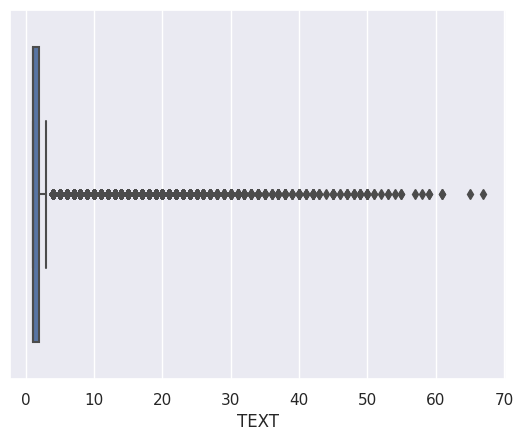

In [6]:
import seaborn as sns
sns.set()


gb_notes = df_notes_nicu.groupby(['CGID','SUBJECT_ID'])
num_notes = gb_notes['TEXT'].count()

print(f'number of notes: min={num_notes.min()}, max={num_notes.max()}, mean={num_notes.mean()},  median={num_notes.median()}')
sns.boxplot(x=num_notes)

check number of caregiver/subject that have between 4 and 15 notes

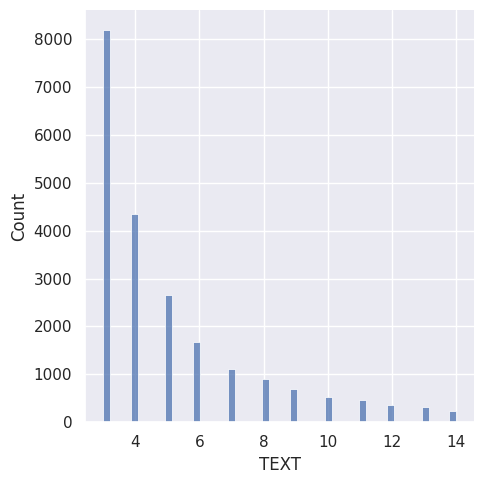

In [8]:
sns.displot(num_notes[((num_notes>2) & (num_notes<15))])

## Embedding and Attitude

### Input data

In [9]:
cg_subjects_dict = {}
caregivers_ids = df_notes_nicu['CGID'].unique()

for cg_id in caregivers_ids:
  cg_subjects_dict[cg_id] = df_notes_nicu[df_notes_nicu['CGID']==cg_id]['SUBJECT_ID'].unique().tolist()

In [10]:
# loop through len(ids)
def create_sentences(cgid=14098, subid=13155):
  df_notes_nicu_selected = df_notes_nicu[(df_notes_nicu['CGID'] == cgid) & (df_notes_nicu['SUBJECT_ID'] == subid)].sort_values(by=['CHARTDATE'])
  sentences = df_notes_nicu_selected['TEXT'].tolist()
  return df_notes_nicu_selected, sentences

df_notes_nicu_selected, sentences = create_sentences()

In [11]:
df_notes_nicu_selected

,ROW_ID,SUBJECT_ID,CGID,CHARTDATE,TEXT
217423,1865577,13155,14098,2154-04-11,0700-1900 NPN\n\n\nFEN: Ad lib with a min of 1...
49919,1865581,13155,14098,2154-04-12,NPN Discharge Note\n\n\nRESP/CV: Infant remain...


### Embeddings 

embedding model

In [12]:
model_ckpt = "sentence-transformers/all-MiniLM-L6-v2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)

get embeddings

In [13]:
def create_dist_data(list_of_sentences):  
  encoded_input = tokenizer(list_of_sentences, padding=True, truncation=True, return_tensors="pt")
  with torch.no_grad():
    model_output = model(**encoded_input)
  token_embeddings = model_output.last_hidden_state  

  def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output.last_hidden_state
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

  # Perform pooling
  sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

  # Normalize embeddings
  sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)

  sentence_embeddings_np = sentence_embeddings.detach().numpy()

  scores = np.zeros((sentence_embeddings_np.shape[0],sentence_embeddings_np.shape[0]))
  dist = []
  for idx in range(sentence_embeddings_np.shape[0]):
    scores[idx,:] = cosine_similarity([sentence_embeddings_np[idx]],sentence_embeddings_np)[0]            
    if idx < len(sentence_embeddings_np)-1:
      dist.append(scores[idx,idx+1])
  return dist

dist = create_dist_data(sentences)

In [14]:
dist

[0.7811174988746643]

### Attitude 

attitude models

In [15]:
# model name from huggingface.co/model name_id:model_name
models_name = {
  'roberta':'tanoManzo/roberta-attitude',
#  'distilbert':'tanoManzo/distilbert-attitude',
#  'minilm':'tanoManzo/minilm-attitude',
#  'bloom':'tanoManzo/bloom-attitude'
}

# load tokenizer and model 
tokenizers = [AutoTokenizer.from_pretrained(model_name) for model_name in models_name.values()]
models= [AutoModelForSequenceClassification.from_pretrained(model_name) for model_name in models_name.values()]

In [44]:
def create_sentiment_labels(df_notes_nicu_selected, list_of_sentences):
  # select dataframe split
  df_to_infer = df_notes_nicu_selected

  # parameters to set 
  total_notes = len(df_to_infer)
  batch_size = 1
  iterations = int(len(df_to_infer)/batch_size)

  # start label creation
  l_scores = {k:[] for k in models_name.keys()} # dict Model: labels 
  l_labels = {k:[] for k in models_name.keys()} # dict Model: scoress
  #print(iterations)
  for iter in range(iterations):
    

    idx_start = batch_size*iter     # first window sentence idx in the dataframe
    idx_end = batch_size*(iter+1)   # last window sentence idx in the dataframe
    
    # get row sentences for batch
    list_of_sentences = list(df_to_infer['TEXT'].iloc[idx_start:idx_end].values)
    #print(len(models_name))
    for (index, (key, value)) in enumerate(models_name.items()):
      
      # tokenized input for the model 
      tokenizer = tokenizers[index]
      batch = tokenizer(list_of_sentences, # list of sentence 
                      padding=True, # add if short 
                      truncation=True, # remove if long 
                      max_length=512, # sent length
                      return_tensors="pt" # to return pytorch tensor (NO for TF)
                      )
      #print(batch)        
      model = models[index]
      with torch.no_grad():
        outputs = model(**batch)
        predictions = F.softmax(outputs.logits, dim=1)
        label_ids = torch.argmax(predictions, dim=1)

        labels = [model.config.id2label[label_id] for label_id in label_ids.tolist()]
        scores = [round(float(predictions[idx][label_id].item()),4) for idx, label_id in enumerate(label_ids.tolist())]
        l_labels[key].extend(labels)
        l_scores[key].extend(scores)
      #print(l_labels)
  return l_labels

l_labels = create_sentiment_labels(df_notes_nicu_selected,sentences)

In [45]:
l_labels

{'roberta': ['Overall Neutral Note', 'Overall Neutral Note']}

In [46]:
df_notes_nicu_selected

,ROW_ID,SUBJECT_ID,CGID,CHARTDATE,TEXT
217423,1865577,13155,14098,2154-04-11,0700-1900 NPN\n\n\nFEN: Ad lib with a min of 1...
49919,1865581,13155,14098,2154-04-12,NPN Discharge Note\n\n\nRESP/CV: Infant remain...


# **Add more data**

Group data and count groupings

In [47]:
#grouped_df = df_notes_nicu.groupby(['CGID','SUBJECT_ID']).size().reset_index(name='count')
grouped_df = df_notes_nicu.groupby(['CGID']).size().reset_index(name='count')
grouped_df.tail(3)

,CGID,count
641,21562,2
642,21563,89
643,21570,209


Select 10 samples within count ranges

In [53]:
percentiles_cgid_subid = [(0.8, 0.85),(0.85, 0.9),(0.9, 0.95),(0.95, 0.975),(0.975, 0.98)]
percentiles_cgid_only = [(0.5, 0.6),(0.6, 0.7),(0.7, 0.75),(0.75, 0.8),(0.8, 0.85)]

filtered_rows = []
for min_pct, max_pct in percentiles_cgid_only:
  min = grouped_df['count'].quantile(min_pct)
  max = grouped_df['count'].quantile(max_pct)

  range_df = grouped_df[(grouped_df['count'] >= min) & (grouped_df['count'] <= max)]

  row = range_df.sample(n=3)
  filtered_rows.append(row)
  
result = pd.concat(filtered_rows)

print(result)
print(list(result['CGID']))
cgids = list(result['CGID'])

      CGID  count
526  20020     10
273  17155     13
562  20482     10
590  20817     61
83   15002     62
254  16954     86
128  15370    204
130  15402    199
236  16638    289
264  17085    322
269  17101    427
109  15167    371
549  20282    587
372  18249    732
472  19199    629
[20020, 17155, 20482, 20817, 15002, 16954, 15370, 15402, 16638, 17085, 17101, 15167, 20282, 18249, 19199]


In [54]:
# write data to rows
df_to_plot = pd.DataFrame(columns = ['CGID','SUBJECT_ID','emb_distance','attitudes'])
#cgids = [14098]
print(cgids)
for cgid in cgids:
  for subject_id in cg_subjects_dict[cgid]:
    df_notes_nicu_selected, sentence = create_sentences(cgid=cgid, subid=subject_id)
    dist = create_dist_data(sentence)
    l_labels = create_sentiment_labels(df_notes_nicu_selected,sentence)
    print([cgid, subject_id, dist, list(*l_labels.values())])
    df_to_plot.loc[len(df_to_plot)] = [cgid, subject_id, dist, list(*l_labels.values())]

[20020, 17155, 20482, 20817, 15002, 16954, 15370, 15402, 16638, 17085, 17101, 15167, 20282, 18249, 19199]
[20020, 25581, [0.4966087341308594, 0.3582078516483307], ['Overall Negative Note', 'Overall Neutral Note', 'Overall Neutral Note']]
[20020, 30176, [0.5194100141525269], ['Overall Neutral Note', 'Overall Neutral Note']]
[20020, 26492, [0.46437036991119385, 0.7944238185882568, 0.7223639488220215], ['Overall Neutral Note', 'Overall Neutral Note', 'Overall Neutral Note', 'Overall Neutral Note']]
[20020, 27648, [], ['Overall Neutral Note']]
[17155, 1113, [0.8100992441177368, 0.8087394833564758, 0.7620784640312195, 0.7747126817703247, 0.6777889132499695, 0.6328842639923096, 0.7247981429100037, 0.7391698360443115, 0.8150549530982971, 0.804926872253418, 0.7152000665664673, 0.7730017304420471], ['Overall Neutral Note', 'Overall Neutral Note', 'Overall Negative Note', 'Overall Negative Note', 'Overall Negative Note', 'Overall Neutral Note', 'Overall Neutral Note', 'Overall Neutral Note', 'Ov

In [55]:
# path and name of the csv file 
PATH_TO_SAVE = "/content/drive/MyDrive/NIH/Data/"
name_file_to_save = 'NOTES_NURSING_TRAJECTORIES_multipleCG.csv'
df_to_plot.to_csv(PATH_TO_SAVE+name_file_to_save,index=False)

In [56]:
df_to_plot

,CGID,SUBJECT_ID,emb_distance,attitudes
0,20020,25581,"[0.4966087341308594, 0.3582078516483307]","[Overall Negative Note, Overall Neutral Note, ..."
1,20020,30176,[0.5194100141525269],"[Overall Neutral Note, Overall Neutral Note]"
2,20020,26492,"[0.46437036991119385, 0.7944238185882568, 0.72...","[Overall Neutral Note, Overall Neutral Note, O..."
3,20020,27648,[],[Overall Neutral Note]
4,17155,1113,"[0.8100992441177368, 0.8087394833564758, 0.762...","[Overall Neutral Note, Overall Neutral Note, O..."
...,...,...,...,...
1649,19199,24970,[],[Overall Neutral Note]
1650,19199,32201,"[0.906644344329834, 0.9553641080856323, 0.9507...","[Overall Neutral Note, Overall Neutral Note, O..."
1651,19199,5854,"[0.9265136122703552, 0.92970871925354, 0.92749...","[Overall Neutral Note, Overall Neutral Note, O..."
1652,19199,30721,"[0.8938273787498474, 0.9695601463317871, 0.925...","[Overall Neutral Note, Overall Neutral Note, O..."


# END 


# **Add labels to graph**

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.ticker import MaxNLocator

In [ ]:
sns.scatterplot(dist)
model_labels = l_labels['roberta']
labels_dict = {'Overall Neutral Note': '0', 'Overall Negative Note': 'N', 'Overall Positive Note': 'P'}
graph_labels = [labels_dict[label] for label in model_labels]

# Add sentiment next to points
for index, row in enumerate(dist):

  x_position = index - 0.15
  x2_position = index + 0.075
  y_position = dist[index] - 0.0075
  plt.text(x_position, y_position, graph_labels[index], fontsize=10, color='red')
  plt.text(x2_position, y_position, graph_labels[index+1], fontsize=10, color='red')

# Title and x/y axes
plt.title("Sentence Comparison of Cosine Similarity and Sentiment")
plt.xlabel("Sentence Comparison")
plt.ylabel("Cosine Similarity")

# X-axis tick marks
ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
new_ticks = [str(i) for i in range(len(graph_labels))]
ax.set_xticklabels(new_ticks)

# Legend
legend_handles = [Rectangle((0, 0), 0, 0, alpha=0, label=f"{short_label}: {original_label}") 
                  for original_label, short_label in labels_dict.items()]
#legend_handles = [Text(0, 0, label=f"{short_label}: {original_label}") for original_label, short_label in labels_dict.items()]

# legend to right of graph
#plt.legend(handles=legend_handles, loc='center left', bbox_to_anchor=(1, 0.5), title='Sentiment')

# legend under graph
plt.legend(handles=legend_handles, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=len(labels_dict), title='Sentence Sentiment')

plt.show()

In [ ]:
sns.scatterplot(dist)
model_labels = l_labels['roberta']
labels_dict = {'Overall Neutral Note': '0', 'Overall Negative Note': 'N', 'Overall Positive Note': 'P'}
graph_labels = [labels_dict[label] for label in model_labels]

# Add sentiment next to points
plt.text(-0.15, dist[0]-.0075, graph_labels[0], fontsize=10, color='red')
for index, row in enumerate(dist):
  if index == 0:
    continue
  x_position = index - 0.5
  x2_position = index + 0.075
  y_position = (dist[index] + dist[index-1] - 0.0075)/2
  plt.text(x_position, y_position, graph_labels[index], fontsize=10, color='red')
plt.text(len(dist)-1+0.075, dist[len(dist)-1]-0.0075, graph_labels[len(dist)], fontsize=10, color='red')

# Title and x/y axes
plt.title("Sentence Comparison of Cosine Similarity and Sentiment")
plt.xlabel("Sentence Comparison")
plt.ylabel("Cosine Similarity")

# X-axis tick marks
ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
new_ticks = [str(i) for i in range(len(graph_labels))]
ax.set_xticklabels(new_ticks)

# Legend
legend_handles = [Rectangle((0, 0), 0, 0, alpha=0, label=f"{short_label}: {original_label}") 
                  for original_label, short_label in labels_dict.items()]
#legend_handles = [Text(0, 0, label=f"{short_label}: {original_label}") for original_label, short_label in labels_dict.items()]

# legend to right of graph
#plt.legend(handles=legend_handles, loc='center left', bbox_to_anchor=(1, 0.5), title='Sentiment')

# legend under graph
plt.legend(handles=legend_handles, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=len(labels_dict), title='Sentence Sentiment')

plt.show()

## Clustering 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

In [ ]:
clustering_model = KMeans(n_clusters=3)
clustering_model.fit(sentence_embeddings_np)
cluster_assignment = clustering_model.labels_
print(cluster_assignment)

In [ ]:
clustered_sentences = {}
for sentence_id, cluster_id in enumerate(cluster_assignment):
    if cluster_id not in clustered_sentences:
        clustered_sentences[cluster_id] = []

    clustered_sentences[cluster_id].append(sentences[sentence_id])
clustered_sentences

In [ ]:
from scipy.spatial.distance import cdist

distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 6)
X = sentence_embeddings_np 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
  
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'cosine'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)
  
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_

In [ ]:
import matplotlib.pyplot as plt
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()